<a href="https://colab.research.google.com/github/lloydoad/disaster-tweet-classifier/blob/master/disaster_tweet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 8.7MB/s 


In [3]:
import string
import spacy
import nltk
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
import keras
import sklearn
import tokenization
import tensorflow_hub as hub
from keras import layers
from keras import Model
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score 

# Summary
## Problem Statement
My final project will be focused on completing the [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview) kaggle competition challenge.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

## Dataset
There are two files being provided. A training set for creating the classifier and a test set for evaluating the performance. 

Each of the datasets have the following columns:
* `id` - an identifier per tweet (row)
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - whether a tweet is about a disaster (`1`) or not (`0`)

# Data Preparation

In [5]:
train_url_path = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/train.csv'
test_url_path = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/test.csv'
train = pd.read_csv(train_url_path, error_bad_lines=False)
test = pd.read_csv(test_url_path, error_bad_lines=False)
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [6]:
train_length, test_length, feature_count = train.shape[0], test.shape[0], test.shape[1]
print('Number of features: ', feature_count)
print('Number of instances in training set: ', train_length)
print('Number of instances in test set: ', test_length)
print('Total number of instances:', train_length + test_length)

Number of features:  3
Number of instances in training set:  7613
Number of instances in test set:  3263
Total number of instances: 10876


## Missing Values

In [7]:
print('First 10 train datapoints')
train.head(10)

First 10 train datapoints


,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,NaN,NaN,There's an emergency evacuation happening now ...,1
9,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
missing_values = {
    'keywords' : [train.keyword.isna().sum(), test.keyword.isna().sum()],
    'location' : [train.location.isna().sum(), test.location.isna().sum()],
    'texts' : [train.text.isna().sum(), test.text.isna().sum()]
}
for feature in missing_values:
  for (dataset, length, values) in zip(['Train', 'Test'], [train_length, test_length], missing_values[feature]):
    print('Number of missing {} in {} dataset: {}'.format(feature, dataset, values))
    print('Percentage of missing {} in {} dataset: {:.2f}%\n'.format(feature, dataset, (values / length) * 100))

Number of missing keywords in Train dataset: 61
Percentage of missing keywords in Train dataset: 0.80%

Number of missing keywords in Test dataset: 26
Percentage of missing keywords in Test dataset: 0.80%

Number of missing location in Train dataset: 2533
Percentage of missing location in Train dataset: 33.27%

Number of missing location in Test dataset: 1105
Percentage of missing location in Test dataset: 33.86%

Number of missing texts in Train dataset: 0
Percentage of missing texts in Train dataset: 0.00%

Number of missing texts in Test dataset: 0
Percentage of missing texts in Test dataset: 0.00%



Looking at the number of missing values for keywords and location for both training and test set, we see that there are more missing locations (**~33%**) than keywords (**~0.8%**)

To fix the missing keywords and locations, we replace these with either `no_keywords` or `no_location`. This will allow these features to be used for sorting later on. 

In [9]:
for dataFrame in [train, test]:
  dataFrame.keyword.fillna('no_keywords', inplace=True)
  dataFrame.location.fillna('no_location', inplace=True)

In [10]:
train.sample(20)

,keyword,location,text,target
3752,fire,To The Right of You!,Politifiact: Harry Reid's '30 Percent of Women...,0
6317,stretcher,"Amazon Seller , Propagandist",Keep shape your shoes ??#Amazon #foot #adjust ...,1
3263,engulfed,no_location,@ZachZaidman @670TheScore wld b a shame if tha...,0
4025,forest%20fire,"Concord, N.C.",Fire in Pisgah National Forest grows to 375 ac...,1
6493,sunk,"San Jose, CA",Its like I never left. I just sunk to the back...,0
3391,evacuation,no_location,Reid Lake fire prompts campground evacuation o...,1
595,bioterror,"Pelham, AL",Thank you @FedEx for no longer shipping live m...,0
6777,tragedy,no_location,shit is hard to get over but sometimes the tra...,1
1201,buildings%20burning,"Madison, GA",@_minimehh @cjoyner I must be overlooking the ...,1
4599,injury,Somewhere in China.,Jack Wilshere has poor injury recordand his of...,1


## Data Cleaning

Each tweet will be cleaned to take out stop words, http links, and extra characters like punctuations or trailing spaces.

In [11]:
nlp = spacy.load('en')
sp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
spacy_stop_words = nlp.Defaults.stop_words
nltk_stop_words = stopwords.words('english')
all_stop_words = spacy_stop_words.union(nltk_stop_words)
print('Number of stop words used for filtering: ', len(all_stop_words))

Number of stop words used for filtering:  382


In [13]:
def clean(tweet):
  # Remove link portion of attachments in tweet
  tweet = re.sub('https?:\/\/t.co\/[A-Za-z0-9]*', '', tweet)
  
  # Remove stop words
  tweet = [word for word in word_tokenize(tweet) if not word.lower() in all_stop_words]
  tweet = ' '.join(tweet)

  # # Remove puntuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))

  # # Remove extra space
  tweet = re.sub("\s+", ' ', tweet)

  return tweet

In [14]:
test_tweet = train.sample(1).values[0,2]
print(
    'Cleaning example\nOriginal Tweet:', test_tweet, 
    'Cleaned Tweet', clean(test_tweet),
    sep='\n'
    )

Cleaning example
Original Tweet:
@JamesMelville Some old testimony of weapons used to promote conflicts
Tactics - corruption &amp; infiltration of groups
https://t.co/cyU8zxw1oH
Cleaned Tweet
 JamesMelville old testimony weapons promote conflicts Tactics corruption amp infiltration groups


In [15]:
train['clean_text'] = train.text.apply(lambda x:clean(x))
test['clean_text'] = test.text.apply(lambda x:clean(x))
train.sample(5)

,keyword,location,text,target,clean_text
6998,twister,"Plano,TX",@briannafrost Twister with Bill Paxton and Hel...,0,briannafrost Twister Bill Paxton Helen Hunt
2237,deluge,Raleigh (Garner/Cleveland) NC,What's missing in the #asae15 exhibitor emails...,0,missing asae15 exhibitor emails Value assnchat
2986,drowning,Pittsburgh,Drowning in Actavis suicide,0,Drowning Actavis suicide
6113,sinking,no_location,That horrible sinking feeling when youÛªve be...,0,horrible sinking feeling youÛªve home phone r...
2743,devastated,Varies,Is Stuart Broad the Prime Minister yet. Best t...,0,Stuart Broad Prime Minister Best thing Sport s...


# Data Visualization

Class distribution shows an almost equal count of both disaster and non-disaster tweets in the training set.

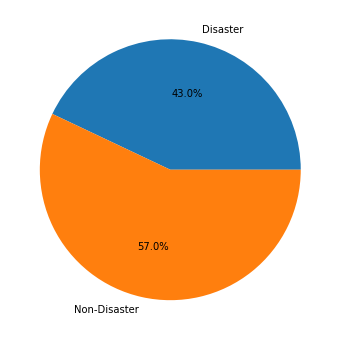

In [52]:
figure(figsize=(6,6))
labels = 'Disaster', 'Non-Disaster'
counts = [train[train.target == 1].shape[0], train[train.target == 0].shape[0]]
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

The frequency of no_keyword and no_location are graphed in both training and test datasets for comparison. From the diagrams we can see that both the training and test dataset have about similar distribution of keywords and locations regardless of their actual lengths.

<Figure size 792x576 with 0 Axes>

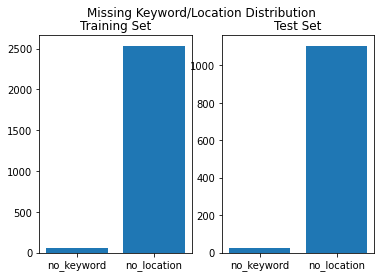

In [17]:
no_keyword = missing_values['keywords']
no_locations = missing_values['location']

figure(figsize=(11,8))
fig, (axes1, axes2) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Missing Keyword/Location Distribution')
axes1.bar(['no_keyword', 'no_location'], [no_keyword[0], no_locations[0]])
axes1.set_title('Training Set')
axes2.bar(['no_keyword', 'no_location'], [no_keyword[1], no_locations[1]])
axes2.set_title('Test Set')
plt.show()

The frequency per unique location is very low. 
There's also multiple locations with different representations that mean the same thing; for example United States and USA.

Location may not be an important factor in classifying texts due to it being varied and 1/3 of the datapoints not having any location feature at all. This is visualized below.

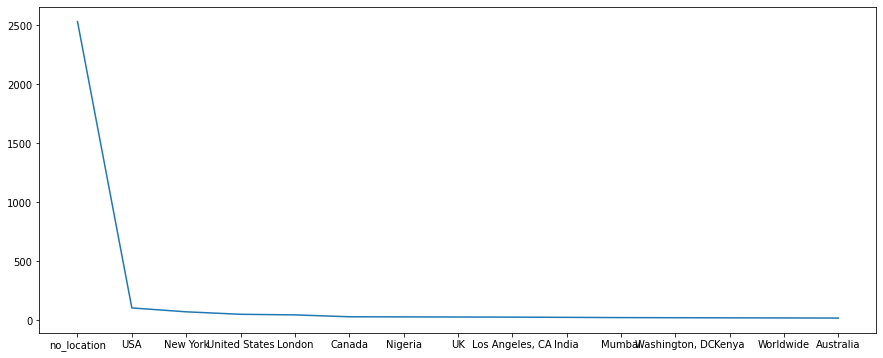

In [18]:
top_15_locations = train.groupby(['location']).count().text.sort_values(ascending=False)[:15]
figure(figsize=(15,6))
plt.plot(top_15_locations)
plt.show()

# Modeling and Cross Validation

Start by downloading the pre-built layers for BERT which we will be adding onto for classification

In [19]:
FullTokenizer = tokenization.FullTokenizer
BERT_BASE_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
BERT_BASE_DISC = 'Base_uncased'

# Two different pretrained layers. A base case layer for working out parameters
# and a larger layer for final classification
bert_base_layer = hub.KerasLayer(BERT_BASE_MODEL_HUB, trainable=False)

# Selected BERT model only takes lowercase strings
to_lower_case = bert_base_layer.resolved_object.do_lower_case.numpy()
base_vocabulary_file = bert_base_layer.resolved_object.vocab_file.asset_path.numpy()
base_tokenizer = FullTokenizer(base_vocabulary_file, to_lower_case)

## Encoding

Encoders are created for converting the `clean_text` into embedded inputs that BERT can understand. It also handles padding the input to fit a maximum length. 

The maximum length is obtained from finding the longest sentence in clean_text column. 

In [20]:
def encode_tweet(text, tokenizer=base_tokenizer):
  # CLS and SEP are attached to end of tokenized word for storing classification weights
  # and separating words respectively
  tokenized_tweet = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(text) + ['[SEP]'])
  return tokenized_tweet

In [21]:
max_token_length = 0
def encode_list(tweet_list=train.clean_text, tokenizer=base_tokenizer, force_max_len=None):
  tokenized_tweets = [encode_tweet(tweet) for tweet in tweet_list]
  if force_max_len:
    max_len = force_max_len
  else:
    max_len = len(max(tokenized_tweets, key = len))
  
  tokens = []
  masks = []
  segments = []

  for token_tweet in tokenized_tweets:
    length = len(token_tweet)
    padded_token_tweet = token_tweet + ([0] * (max_len - length))
    padded_token_mask = (length * [1]) + ([0] * (max_len - length))
    segment = [0] * max_len

    tokens.append(padded_token_tweet)
    masks.append(padded_token_mask)
    segments.append(segment)
  
  print('Maximum token length: ', max_len)
  max_token_length = max_len
  return np.array(tokens), np.array(masks), np.array(segments)

def encode_dataset(dataset=train, tokenizer=base_tokenizer, force_max_len=None):
  return encode_list(dataset.clean_text, tokenizer=tokenizer, force_max_len=force_max_len)

Create classification model that defaults to the following parameters: 
* BERT base layer
* 0.0001 learning rate
* An extra hidden layer attached to BERT prebuilt layers
* Sigmoid Activation function in the last layer
* Adam optimizer
* BCE loss function measuring accuracy

In [22]:
def create_model(bert_layer=bert_base_layer,
                 name='default_function_model',
                 bert_trainable=False,
                 add_hidden_layer=True,
                 input_length=128,
                 lr = 0.0001, 
                 momentum = 0.8,
                 activation='sigmoid', 
                 optimizer='Adam',
                 metrics=['accuracy'], 
                 loss = 'binary_crossentropy'):
  if bert_trainable:
    print('Will also train bert layers')
  bert_layer.trainable = bert_trainable

  # Define the shape for the input layer
  input_tokens = Input(shape=(input_length,), dtype='int32', name='input_tokens')
  input_masks = Input(shape=(input_length,), dtype='int32', name='input_masks')
  input_segments = Input(shape=(input_length,), dtype='int32', name='input_segments')
  pooled_output, sequence_output = bert_layer([input_tokens, input_masks, input_segments])
  
  cls_layer = sequence_output[:, 0, :]
  # Define hidden and output layer
  if add_hidden_layer:
    print('Adding hidden layer with 256 units on top of bert layer')
    hidden = Dense(256, activation=activation)(cls_layer)
    hiddenDropout = Dropout(0.5)(hidden)
    output = Dense(1, activation=activation)(hiddenDropout)
  else:
    output = Dense(1, activation=activation)(cls_layer)

  # Assemble model
  model = Model(
      inputs=[input_tokens, input_masks, input_segments], 
      outputs=output,
      name=name
      )
  
  print('Using {} optimizer'.format(optimizer))
  if optimizer == 'Adam':
    optimizer = Adam(learning_rate=lr)
  elif optimizer == 'RMSProp':
    optimizer = RMSprop(learning_rate=lr)
  elif optimizer == 'SGD':
    optimizer = SGD(learning_rate=lr, momentum=momentum)
  
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model

def get_model(
    name='default_model', 
    word_length=128,
    optimizer='Adam',
    add_hidden_layer=True,
    train_bert=False
    ):
  checkpoint = ModelCheckpoint(name + '.h5', monitor='val_loss', save_best_only=True)
  return create_model(
      name=name, 
      input_length=word_length,
      bert_trainable=train_bert,
      add_hidden_layer=add_hidden_layer,
      optimizer=optimizer
      )

## Picking Hyper-parameters

For the finetuning, a default model is trained for 1 epoch to monitor validation accuracy and hyper-parameters

In [23]:
X = encode_dataset(dataset=train, tokenizer=base_tokenizer)
y = train.target
max_word_length = X[0].shape[1]
_ = get_model('prep_model', word_length=max_word_length).fit(X, y, shuffle=True, validation_split=0.35, batch_size=32, epochs=1)

Maximum token length:  53
Adding hidden layer with 256 units on top of bert layer
Using Adam optimizer
155/155 [==============================] - 28s 182ms/step - loss: 0.6927 - accuracy: 0.5883 - val_loss: 0.5723 - val_accuracy: 0.7505


Second possible model takes uses a different optimizer (RMSProp)

In [24]:
X = encode_dataset(dataset=train, tokenizer=base_tokenizer)
get_model('prep_model_rmsprop', word_length=max_word_length, optimizer='RMSProp').fit(X, y, shuffle=True, validation_split=0.35, batch_size=32, epochs=1)

Maximum token length:  53
Adding hidden layer with 256 units on top of bert layer
Using RMSProp optimizer
155/155 [==============================] - 30s 191ms/step - loss: 0.6662 - accuracy: 0.6099 - val_loss: 0.5531 - val_accuracy: 0.7538


Third possible model takes uses a different optimizer (SGD)

In [25]:
X = encode_dataset(dataset=train, tokenizer=base_tokenizer)
get_model('prep_model_rmsprop', word_length=max_word_length, optimizer='SGD').fit(X, y, shuffle=True, validation_split=0.35, batch_size=32, epochs=1)

Maximum token length:  53
Adding hidden layer with 256 units on top of bert layer
Using SGD optimizer
155/155 [==============================] - 30s 195ms/step - loss: 0.7360 - accuracy: 0.5305 - val_loss: 0.6896 - val_accuracy: 0.5546


## Training

For the full model, we will use cross-validation fold to improve performance for our dataset. To similate the equal split in the training and test dataset, we will split the training set into folds by using the keywords via stratification.

We will also use RMSProp for our optimizer since it had the best performance from our preliminary tests.

In [26]:
seed_for_split = 1996
number_of_folds = 2
stratified_kf = StratifiedKFold(n_splits=number_of_folds, random_state=seed_for_split, shuffle=True)

print('We use the keyword as a key for spliting our train data to get an even spread\nof keywords across both the training dataset and the validation dataset')
for fold, (trn_idx, val_idx) in enumerate(stratified_kf.split(train.clean_text, train.target), 1):
  train_set = train.loc[trn_idx]
  train_val = train.loc[trn_idx]
  print('\nFold {} Training dataset = {} - Validation dataset = {}'.format(fold, train_set.clean_text.shape, train_val.clean_text.shape))
  print('Unique keyword Count = Train Set {} - Validation Set {}'.format(train_set.keyword.nunique(), train_val.keyword.nunique()))    

We use the keyword as a key for spliting our train data to get an even spread
of keywords across both the training dataset and the validation dataset

Fold 1 Training dataset = (3806,) - Validation dataset = (3806,)
Unique keyword Count = Train Set 222 - Validation Set 222

Fold 2 Training dataset = (3807,) - Validation dataset = (3807,)
Unique keyword Count = Train Set 222 - Validation Set 222


Classification Report class is created to moniter accuracy and progress during epochs. This covers more measures in details as compared the usual accuracy for default fit function.
[ClassificationReport code credit](https://colab.research.google.com/github/goswami-rahul/machine-learning/blob/master/UnderstandingMetrics.ipynb)

In [27]:
class ClassificationReport(Callback):
  def __init__(self, train_data=(), validation_data=()):
    super(Callback, self).__init__()
    
    self.X_train, self.y_train = train_data
    self.train_precision_scores = []
    self.train_recall_scores = []
    self.train_f1_scores = []
    
    self.X_val, self.y_val = validation_data
    self.val_precision_scores = []
    self.val_recall_scores = []
    self.val_f1_scores = [] 
              
  def on_epoch_end(self, epoch, logs={}):
    train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
    train_precision = precision_score(self.y_train, train_predictions, average='macro')
    train_recall = recall_score(self.y_train, train_predictions, average='macro')
    train_f1 = f1_score(self.y_train, train_predictions, average='macro')
    self.train_precision_scores.append(train_precision)        
    self.train_recall_scores.append(train_recall)
    self.train_f1_scores.append(train_f1)
    
    val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
    val_precision = precision_score(self.y_val, val_predictions, average='macro')
    val_recall = recall_score(self.y_val, val_predictions, average='macro')
    val_f1 = f1_score(self.y_val, val_predictions, average='macro')
    self.val_precision_scores.append(val_precision)        
    self.val_recall_scores.append(val_recall)        
    self.val_f1_scores.append(val_f1)
    
    print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
    print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1)) 

Each fold of the dataset is used to train a model which is added to an ensemble of `trained_models` from previous folds

In [28]:
full_model_name = 'full_model'
number_of_epochs = 10
trained_models = []
scores = {}

def train_main_models():
  for fold, (trn_idx, val_idx) in enumerate(stratified_kf.split(train.clean_text, train.target), 1):
    print('Training Fold ', fold)
    train_set = train.loc[trn_idx]
    train_val = train.loc[trn_idx]

    # Split into train and validation sets
    X_train, y_train = encode_list(train_set.clean_text), train_set.target
    X_val, y_val = encode_list(train_val.clean_text), train_val.target 

    # Train and monitor accuracy, recall, and f1-score
    metrics = ClassificationReport(train_data=(X_train, y_train), validation_data=(X_val, y_val))
    curr_model_name = full_model_name + '_{}'.format(fold)
    model = get_model(name=curr_model_name, word_length=max_word_length, optimizer='RMSProp', add_hidden_layer=False, train_bert=True)
    model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), callbacks=[metrics], epochs=number_of_epochs, batch_size=32)

    # Add model to ensemble
    trained_models.append(model)
    print('Current models trained', len(trained_models))

    # Save scores from metrics
    scores[fold] = {
      'train': {
        'precision': metrics.train_precision_scores,
        'recall': metrics.train_recall_scores,
        'f1': metrics.train_f1_scores                    
      },
      'validation': {
        'precision': metrics.val_precision_scores,
        'recall': metrics.val_recall_scores,
        'f1': metrics.val_f1_scores                    
      }
    }
  
  print('Total number of models trained: ', len(trained_models))

# Start training
train_main_models()

Training Fold  1
Maximum token length:  53
Maximum token length:  53
Will also train bert layers
Using RMSProp optimizer
Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.7388
Epoch: 1 - Training Precision: 0.859281 - Training Recall: 0.855056 - Training F1: 0.856867
Epoch: 1 - Validation Precision: 0.859281 - Validation Recall: 0.855056 - Validation F1: 0.856867
119/119 [==============================] - 90s 754ms/step - loss: 0.5668 - accuracy: 0.7388 - val_loss: 0.3711 - val_accuracy: 0.8605
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.8395
Epoch: 2 - Training Precision: 0.89058 - Training Recall: 0.81842 - Training F1: 0.828818
Epoch: 2 - Validation Precision: 0.89058 - Validation Recall: 0.81842 - Validation F1: 0.828818
119/119 [==============================] - 89s 747ms/step - loss: 0.4054 - accuracy: 0.8395 - val_loss: 0.3369 - val_accuracy: 0.8437
Epoch 3/10
119/119 [=======================

# Evaluation

## Prediction

A separate submissions dataset is downloaded to get the target classes for measuring prediction accuracy. The test dataset is then filtered to only contain the cleaned text and the targets.

In [33]:
test_target_url = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/test_target.csv'
test_target = pd.read_csv(test_target_url, error_bad_lines=False).drop(['id'], axis=1)
prepped_test = pd.concat([test])
prepped_test['target'] = test_target.astype(int)
prepped_test.drop(['keyword', 'location', 'text'], axis=1, inplace=True)

By combining all the models that have been fully trained, we are able to achieve an F1 score above **0.8**.

In [34]:
def predict(test=prepped_test, tokenizer=base_tokenizer, force_max_len=max_word_length):
  X_test = encode_dataset(dataset=test, tokenizer=tokenizer, force_max_len=force_max_len)
  pred_y = np.zeros((test.target.shape[0], 1))
  numberOfModels = len(trained_models)
  for model in trained_models:
    pred_y += model.predict(X_test) / numberOfModels
  return pred_y

predicted_y = predict()
pred_values = np.round(predicted_y).astype('int').reshape(1,-1)[0]
true_values = prepped_test.target.values
score = sklearn.metrics.f1_score(true_values, pred_values, average='micro')
print('The F1 Score of the prediction:', score)

Maximum token length:  53
The F1 Score of the prediction: 0.8081520073551947


## Performance Summary

Plotting the accuracy scores for all folds shows a gradual increase over time with the score plateauing after going above **0.975**

In [39]:
def plot_scores(fold=1):
  figure(figsize=(12,7))

  foldValues = scores[fold]
  validationValues = foldValues['validation']
  precision_values = validationValues['precision']
  recall_values = validationValues['recall']
  f1_values = validationValues['f1']
  rangeOfEpochs = np.arange(1, number_of_epochs + 1)

  plt.plot(rangeOfEpochs, precision_values, label='Precision Scores')
  plt.plot(rangeOfEpochs, recall_values, label='Recall Scores')
  plt.plot(rangeOfEpochs, f1_values, label='F1 Scores')
  plt.xlabel('Epochs')
  plt.ylabel('Scores')
  plt.title('Epoch vs. Score (Model {})'.format(fold))
  plt.legend()
  plt.show()

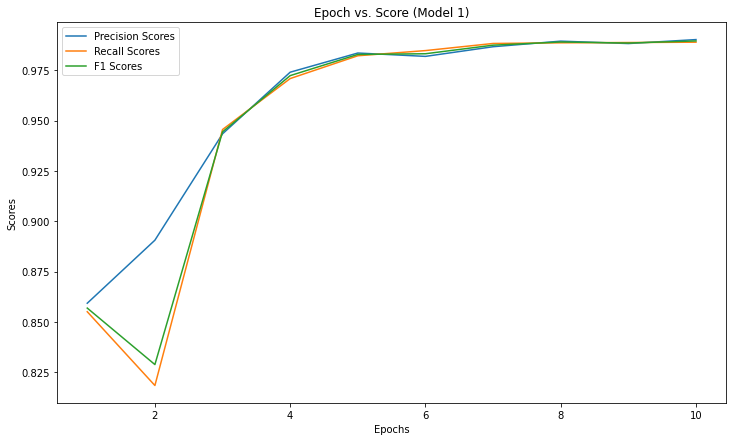

In [40]:
plot_scores(fold=1)

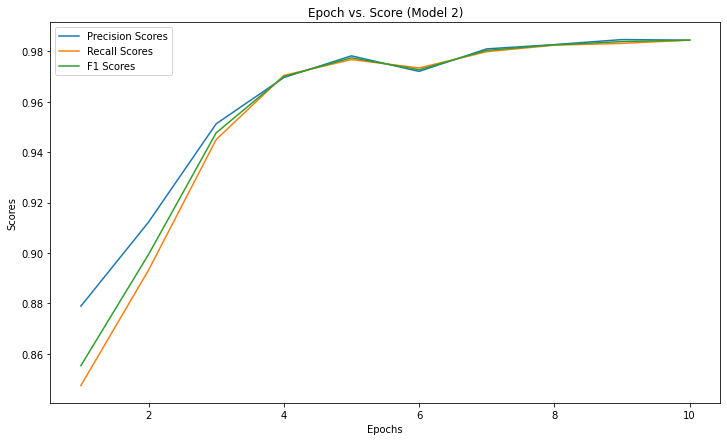

In [41]:
plot_scores(fold=2)

Since both models had similar performance, the values of only one model's accuracy can be looked at to compare to our test set performance. We can see that although high validation scores are achieved during training, the prediction still averages around 0.8 f1 score.

In [51]:
foldValues = scores[1]
validationValues = foldValues['validation']
precision_values = validationValues['precision']
recall_values = validationValues['recall']
f1_values = validationValues['f1']
values = np.array([precision_values, recall_values, f1_values]).transpose()
pd.DataFrame(values, columns=['Precision', 'Recall', 'F1 Score'])

,Precision,Recall,F1 Score
0,0.859281,0.855056,0.856867
1,0.890580,0.818420,0.828818
2,0.943395,0.945527,0.944382
3,0.974001,0.970842,0.972301
4,0.983523,0.982165,0.982820
5,0.981858,0.984736,0.983165
6,0.986652,0.988269,0.987423
7,0.989424,0.988594,0.989000
8,0.988228,0.988738,0.988479
9,0.990202,0.988904,0.989532


Based on the results, we can note the following:
* The optimizer choice doesn't have a significant impact on performance since they could have all reached a validation f1 score above 0.8 in less than 10 epochs
* Having more folds may have improved our performance but the trade-off in time would be noticeable
* Our model uses a 12 layer pre-trained BERT model and trains these as well for our dataset. Using a 16 layer may have improved the performance but the training time would increase by a significant amount
* In conclusion, using an list of models based on two separate folds is a good method for quickly (within 10 epochs) achieving a validation f1 score above 0.9.

# References

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
* https://www.kaggle.com/c/nlp-getting-started/overview
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#8.-Test-Set-Labels
* https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
* https://mccormickml.com/2019/07/22/BERT-fine-tuning/
* https://www.searchenginejournal.com/bert-explained-what-you-need-to-know-about-googles-new-algorithm/337247/
* https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270